## Step 1: Load and Prepare Digits Dataset

In [15]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader

# Load data
digits = load_digits()
X = digits.data
y = digits.target

#scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Wrap in DataLoader
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)

## Data Insights and Visualisation

In [2]:
X.shape

(1797, 64)

In [3]:
y.shape

(1797,)

In [4]:
X[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [5]:
y[0]

np.int64(0)

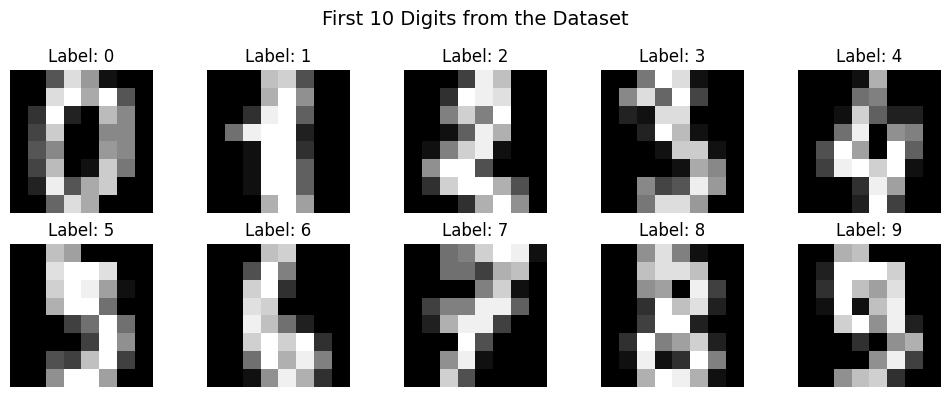

In [6]:
import matplotlib.pyplot as plt

# Set up 2x5 plot
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
fig.suptitle("First 10 Digits from the Dataset", fontsize=14)

for i in range(10):
    row, col = divmod(i, 5)
    ax = axes[row][col]
    ax.imshow(X[i].reshape(8, 8), cmap='gray')
    ax.set_title(f"Label: {y[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## Training : Linear Classifier(No Hidden Layers)

In [7]:
# import torch.nn as nn

# class DigitsNN(nn.Module):
#     def __init__(self):
#         super(DigitsNN, self).__init__()
#         self.linear = nn.Linear(64, 10) # Input 64 (8x8) features and out 10(0-9)
#     def forward(self, x):
#         return self.linear(x)

# model = DigitsNN()

# criterion = nn.CrossEntropyLoss()  # combines softmax + cross-entropy
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## Training : Deep Model(Hidden Layers)

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class DigitsNN(nn.Module):
    def __init__(self):
        super(DigitsNN, self).__init__()
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)  # logits

model = DigitsNN()

criterion = nn.CrossEntropyLoss()  # combines softmax + cross-entropy
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [17]:
def train(model, loader, criterion, optimizer, epochs=100):
    model.train()
    for epoch in range(epochs):
        for X_batch, y_batch in loader:
            # Forward
            logits = model(X_batch)
            loss = criterion(logits, y_batch)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

In [18]:
train(model, train_loader, criterion, optimizer)

Epoch 10/100, Loss: 0.4021
Epoch 20/100, Loss: 0.0001
Epoch 30/100, Loss: 0.0000
Epoch 40/100, Loss: 0.0001
Epoch 50/100, Loss: 0.0000
Epoch 60/100, Loss: 0.0000
Epoch 70/100, Loss: 0.0000
Epoch 80/100, Loss: 0.0000
Epoch 90/100, Loss: 0.0000
Epoch 100/100, Loss: 0.0000


In [19]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model.eval()
with torch.no_grad():
    logits = model(X_test_tensor)
    y_pred = torch.argmax(logits, dim=1)  

accuracy =  accuracy_score(y_test_tensor.numpy(), y_pred.numpy())
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.97


In [20]:
print("\nClassification Report:\n")
print(classification_report(y_test_tensor, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        33
           1       0.96      0.96      0.96        28
           2       0.94      0.97      0.96        33
           3       0.97      0.97      0.97        34
           4       1.00      1.00      1.00        46
           5       0.96      0.98      0.97        47
           6       0.97      1.00      0.99        35
           7       0.97      0.97      0.97        34
           8       1.00      0.93      0.97        30
           9       0.97      0.97      0.97        40

    accuracy                           0.97       360
   macro avg       0.98      0.97      0.97       360
weighted avg       0.98      0.97      0.98       360



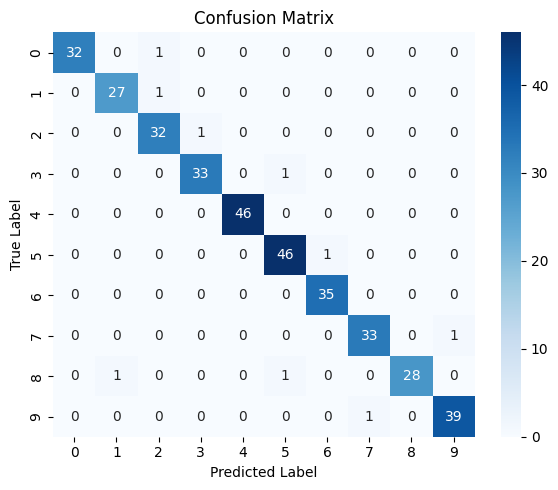

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns  # optional, for better visuals
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test_tensor, y_pred)
labels = digits.target_names
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [14]:
import pandas as pd
df = pd.DataFrame({
    'True Values' : y_test_tensor,
    'Predicted Values' : y_pred
})

df.head(10)

,True Values,Predicted Values
0,6,6
1,9,9
2,3,3
3,7,7
4,2,2
5,1,1
6,5,5
7,2,2
8,5,5
9,2,2
